In [33]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from datasist.structdata import detect_outliers



## other
#from imblearn.over_sampling import SMOTE

## sklearn -- preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_features.transformers import DataFrameSelector
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

## sklearn -- models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor

## skelarn -- metrics
from sklearn.metrics import f1_score, accuracy_score, r2_score

## ensemble models
from sklearn.ensemble import VotingRegressor,  AdaBoostRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor

## `Dataset`

### `Data URL`
- https://www.kaggle.com/code/touba7/insurance-prediction-with-five-regressor-models/data

### `Read Dataset`

In [34]:
df = pd.read_csv("houses.csv", na_values=['Unknown', '', 'na', 'nan', 'NA', 'NAN', '-' ])

# Drop index column and description column 
df.drop(['Ad List', 'description'], axis=1, inplace=True)
df.head(3)

,Bedroom,Bathroom,Property Size,Nearby School,Nearby Mall,Category,Facilities,Building Name,Developer,Tenure Type,...,REN Number,Bus Stop,Mall,Park,School,Hospital,price,Highway,Nearby Railway Station,Railway Station
0,4.0,2.0,1000 sq.ft.,Sekolah Menengah Pendidikan Khas Cacat Penglih...,Setapak Central,"Apartment / Condominium, For sale",NaN,Kenwingston Platz,Kenwingston Group,Freehold,...,NaN,Bus Stop Starparc Point\r\nBus Stop Setapak Ce...,Setapak Central,"Park at Taman Tasik Danau Kota, Setapak, Kuala...",Sekolah Menengah Pendidikan Khas Cacat Penglih...,Columbia Asia Hospital,RM 340 000,NaN,NaN,NaN
1,3.0,2.0,980 sq.ft.,NaN,NaN,"Apartment / Condominium, For sale","Parking, Security, Swimming Pool, Playground, ...",Kenanga (Park View Court),NaN,Freehold,...,REN 15862,NaN,NaN,NaN,NaN,NaN,RM 250 000,NaN,NaN,NaN
2,3.0,2.0,1000 sq.ft.,NaN,NaN,"Apartment / Condominium, For sale","Playground, Minimart, Jogging Track, Barbeque ...",Sri Lavender Apartment,TLS Group,Freehold,...,NaN,NaN,NaN,NaN,NaN,NaN,RM 230 000,SILK Sg Ramal (T) Toll Plaza,NaN,NaN


In [35]:
df.shape

(4000, 30)

### `Replace spaces inside columns names with underscore`

In [36]:
# trim and replace space inside columns names with _
df.columns = df.columns.str.lower().str.strip().str.strip().str.replace(' ', '_')
df.rename(columns={'#_of_floors':'number_of_floors'}, inplace=True)
df.columns

Index(['bedroom', 'bathroom', 'property_size', 'nearby_school', 'nearby_mall',
       'category', 'facilities', 'building_name', 'developer', 'tenure_type',
       'address', 'completion_year', 'number_of_floors', 'total_units',
       'property_type', 'parking_lot', 'floor_range', 'land_title',
       'firm_type', 'firm_number', 'ren_number', 'bus_stop', 'mall', 'park',
       'school', 'hospital', 'price', 'highway', 'nearby_railway_station',
       'railway_station'],
      dtype='object')

### `Check the datatypes of the columns`

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bedroom                 3999 non-null   float64
 1   bathroom                3999 non-null   float64
 2   property_size           4000 non-null   object 
 3   nearby_school           687 non-null    object 
 4   nearby_mall             365 non-null    object 
 5   category                4000 non-null   object 
 6   facilities              3359 non-null   object 
 7   building_name           3913 non-null   object 
 8   developer               2269 non-null   object 
 9   tenure_type             4000 non-null   object 
 10  address                 3913 non-null   object 
 11  completion_year         1979 non-null   float64
 12  number_of_floors        2251 non-null   float64
 13  total_units             2098 non-null   float64
 14  property_type           4000 non-null   

In [38]:
df.describe()

,bedroom,bathroom,completion_year,number_of_floors,total_units,parking_lot
count,3999.000000,3999.000000,1979.000000,2251.000000,2098.000000,2781.000000
mean,2.917229,2.019755,2011.383527,21.650378,614.005243,1.506652
std,0.691838,0.607490,8.001577,25.792521,591.703145,0.700238
min,1.000000,1.000000,1985.000000,2.000000,1.000000,1.000000
25%,3.000000,2.000000,2006.000000,12.000000,290.000000,1.000000
50%,3.000000,2.000000,2014.000000,20.000000,462.000000,1.000000
75%,3.000000,2.000000,2017.000000,27.000000,753.500000,2.000000
max,10.000000,8.000000,2026.000000,504.000000,7810.000000,10.000000


In [39]:
df.describe(include=['O'])

,property_size,nearby_school,nearby_mall,category,facilities,building_name,developer,tenure_type,address,property_type,...,ren_number,bus_stop,mall,park,school,hospital,price,highway,nearby_railway_station,railway_station
count,4000,687,365,4000,3359,3913,2269,4000,3913,4000,...,2964,708,475,807,948,343,4000,141,363,485
unique,849,253,92,1,2201,1937,580,2,1828,8,...,962,336,132,357,429,79,562,31,93,142
top,700 sq.ft.,Vikas International School,Setapak Central,"Apartment / Condominium, For sale","Parking, Security, Lift, Swimming Pool, Playgr...",All Seasons Park,Ideal Property Group,Freehold,"Lebuhraya Thean Teik, Ayer Itam, Penang",Condominium,...,REN 22963,Bus Stop KL 1284 Wisma Buddist\r\nBus Stop KL ...,Mid Valley Megamall,"Park at Taman Halimahton, Seputeh, Kuala Lumpu...",Vikas International School,Columbia Asia Hospital,RM 350 000,Loke Yew Toll Plaza,KTM Station Batu Caves (Komuter Seremban Line),KTM Station Batu Caves (Komuter Seremban Line)
freq,201,19,19,4000,142,25,68,2426,40,1714,...,86,26,26,26,26,26,81,17,23,35


## `Data Cleaning`

### `Check number of NA cells in each column`

In [40]:
# print the percentage of null cells in each column ordered desc 
df.isna().sum().sort_values(ascending=False) / df.shape[0]

highway                   0.96475
hospital                  0.91425
nearby_railway_station    0.90925
nearby_mall               0.90875
mall                      0.88125
railway_station           0.87875
nearby_school             0.82825
bus_stop                  0.82300
park                      0.79825
school                    0.76300
completion_year           0.50525
total_units               0.47550
number_of_floors          0.43725
developer                 0.43275
parking_lot               0.30475
floor_range               0.26550
ren_number                0.25900
firm_type                 0.18775
firm_number               0.18775
facilities                0.16025
address                   0.02175
building_name             0.02175
bathroom                  0.00025
bedroom                   0.00025
land_title                0.00000
property_type             0.00000
tenure_type               0.00000
price                     0.00000
category                  0.00000
property_size 

### `Drop columns that have nullable values more than 70% of its size`

In [41]:
empty_cells_percentages = df.isna().sum().sort_values(ascending=False) / df.shape[0]
columns = empty_cells_percentages[empty_cells_percentages > 0.7].index
df.drop(columns, axis=1, inplace=True)
df.shape

(4000, 20)

### `Convert Property-size to numerical by removing 'sq.ft'`

In [42]:
def fix_property_size(value:str):
    return value.replace('sq.ft.', '').strip()
df['property_size'] = df['property_size'].apply(fix_property_size).astype(float)
df['property_size'].describe()

count      4000.000000
mean       1035.049000
std        2012.250439
min           1.000000
25%         750.000000
50%         900.000000
75%        1120.000000
max      122774.000000
Name: property_size, dtype: float64

### `Drop column Category because it contains only one value`

In [43]:
df.drop(['category'], axis=1, inplace=True)

### `Remove the currency 'RM' (Malaysian Ringgit) from price column`

In [44]:
def fix_price(value:str):
    if isinstance(value, float):
        return value
    else:
        modified_value = value.replace(' ', '').replace('RM', '')
        return float(modified_value) 

df['price'] = df['price'].apply(fix_price) 
df['price'].describe()

count    4.000000e+03
mean     4.218269e+05
std      3.286249e+05
min      3.800000e+04
25%      2.500000e+05
50%      3.500000e+05
75%      4.900000e+05
max      6.016000e+06
Name: price, dtype: float64

### `Drop address column`

In [45]:
df.drop(['address'], axis=1, inplace=True)

### `Convert the fload fields which are discrete to int type`

In [46]:
df['bedroom'] = df['bedroom'].astype('Int64')
df['bathroom'] = df['bathroom'].astype('Int64')
df['completion_year'] = df['completion_year'].astype('Int64')
df['number_of_floors'] = df['number_of_floors'].astype('Int64')
df['total_units'] = df['total_units'].astype('Int64')
df['parking_lot'] = df['parking_lot'].astype('Int64')

## `Feature Engineering`

### `Column Facilities contains multiple categories, extract each category into separate column and drop 'Facilities'`

In [47]:
def split_facilities_into_separate_columns(df):
    for index in df.index:
        facilities = df.loc[index, 'facilities']
        
        if type(facilities) == str:
    
            parts = facilities.split(',')

            # loop on each facility 
            for part in parts:
                part = part.strip()
            
                if part not in df.columns:
                    # initialize new column with value False
                    df.loc[:, part] = False
                    
                # indicate that the current row has this facility
                df.loc[index, part] = True
    return df

df = split_facilities_into_separate_columns(df)
df.describe(include='bool')

,Parking,Security,Swimming Pool,Playground,Barbeque area,Jogging Track,Minimart,Lift,Gymnasium,Multipurpose hall,Sauna,Tennis Court,Club house,Squash Court,10
count,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False
freq,3039,3018,2404,2733,2526,2595,2396,2097,2026,2690,2941,3315,3378,3403,3998


In [48]:
df.shape

(4000, 33)

In [49]:
df.drop(['facilities'], axis=1, inplace=True)

### `Extract from property-agent-number field (REN-Number) the type (REN - PEA - E - REA - PV - V) and the number`

In [59]:
def split_agent_number(value):
    if isinstance(value, float):
        return pd.Series([np.nan, float(value)])
    else:
        parts = value.split(' ')
        return pd.Series([parts[0], float(parts[1])]) 
 
df[['ren_type', 'ren_number']] =  df['ren_number'].apply(split_agent_number) 
df['ren_number'] = df['ren_number'].astype('Int64')


In [60]:
df[['ren_type', 'ren_number']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ren_type    2964 non-null   object
 1   ren_number  2964 non-null   Int64 
dtypes: Int64(1), object(1)
memory usage: 66.5+ KB


In [61]:
df['ren_type'].value_counts()

ren_type
REN    2722
PEA     139
E        71
REA      24
PV        5
V         3
Name: count, dtype: int64

## `Visualization`

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedroom            3999 non-null   Int64  
 1   bathroom           3999 non-null   Int64  
 2   property_size      4000 non-null   float64
 3   building_name      3913 non-null   object 
 4   developer          2269 non-null   object 
 5   tenure_type        4000 non-null   object 
 6   completion_year    1979 non-null   Int64  
 7   number_of_floors   2251 non-null   Int64  
 8   total_units        2098 non-null   Int64  
 9   property_type      4000 non-null   object 
 10  parking_lot        2781 non-null   Int64  
 11  floor_range        2938 non-null   object 
 12  land_title         4000 non-null   object 
 13  firm_type          3249 non-null   object 
 14  firm_number        3249 non-null   object 
 15  ren_number         2964 non-null   Int64  
 16  price              4000 

 
boxplot of charges


### `Draw histogram for numerical fields`

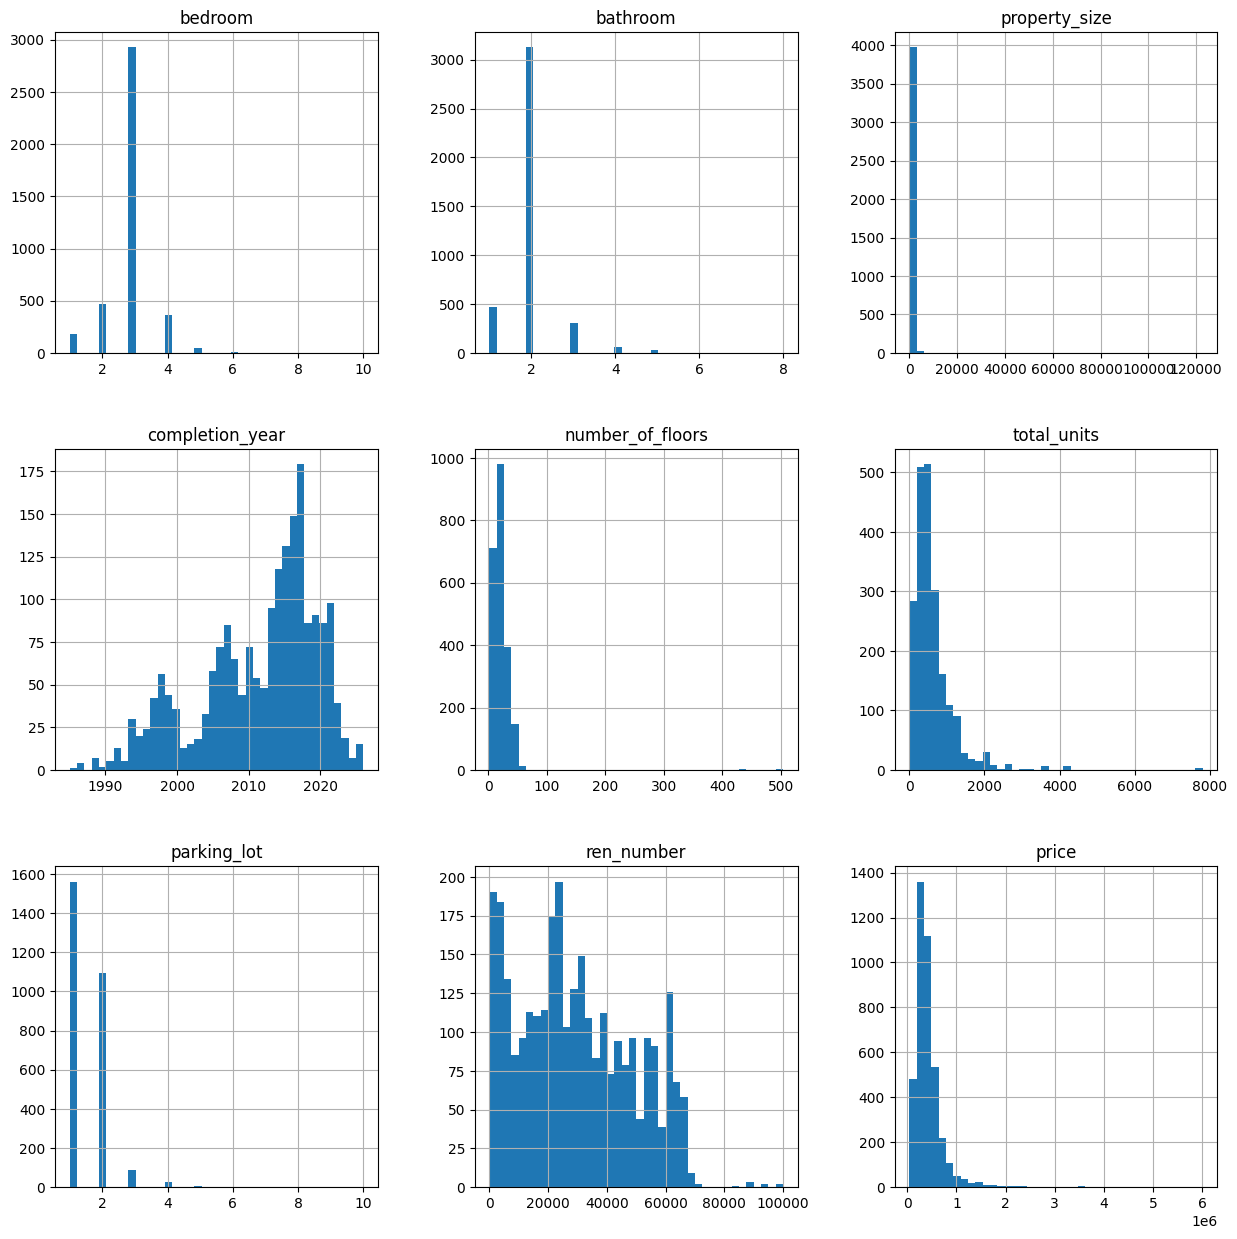

In [63]:
df.hist(bins=40, figsize=(15,15))
plt.show()


In [64]:
sns.set_theme(style="ticks")
#sns.pairplot(df, hue="species")
sns.pairplot(df)

KeyError: 'species'

Error in callback <function _draw_all_if_interactive at 0x000001ABF722FBA0> (for post_execute):


KeyboardInterrupt: 

##### `Draw histogram of Body mass index "bmi"  given gender`

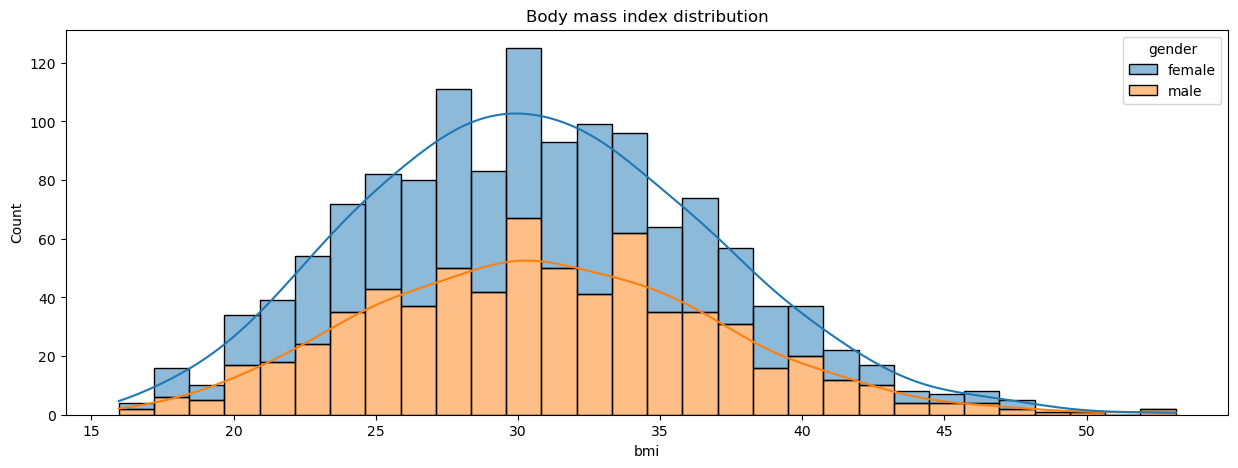

In [86]:
plt.figure(figsize=(15,5))
sns.histplot(data=df, x='bmi', hue='gender', bins=30, multiple='stack', kde=True)
plt.title('Body mass index distribution')
plt.show()

##### `Draw number of smokers/non-smokers divided by age_group`

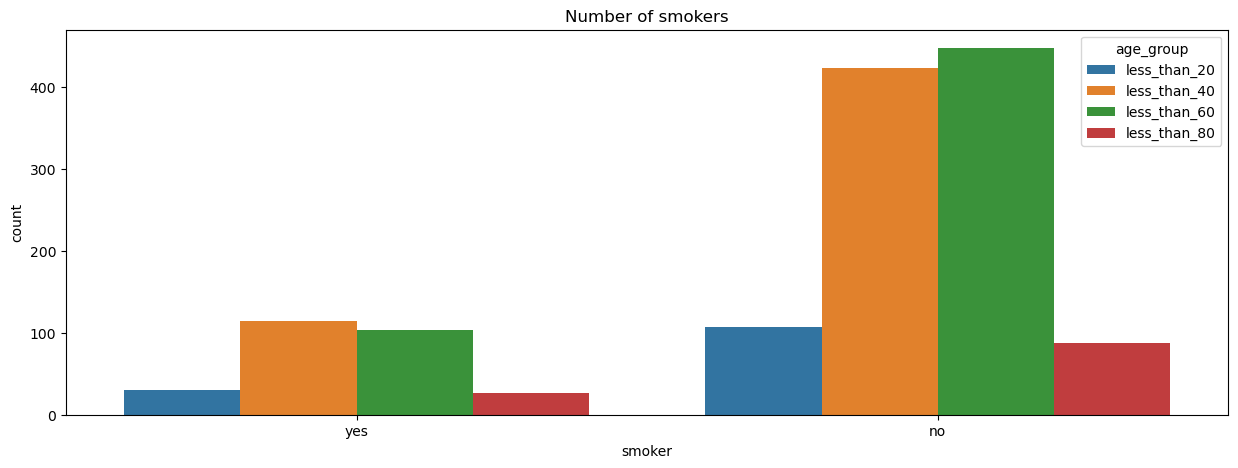

In [87]:
plt.figure(figsize=(15,5))
sns.countplot(data=df, x='smoker', hue='age_group')
plt.title('Number of smokers')
plt.show()

##### `Draw number of clients in each region divided by age_group`

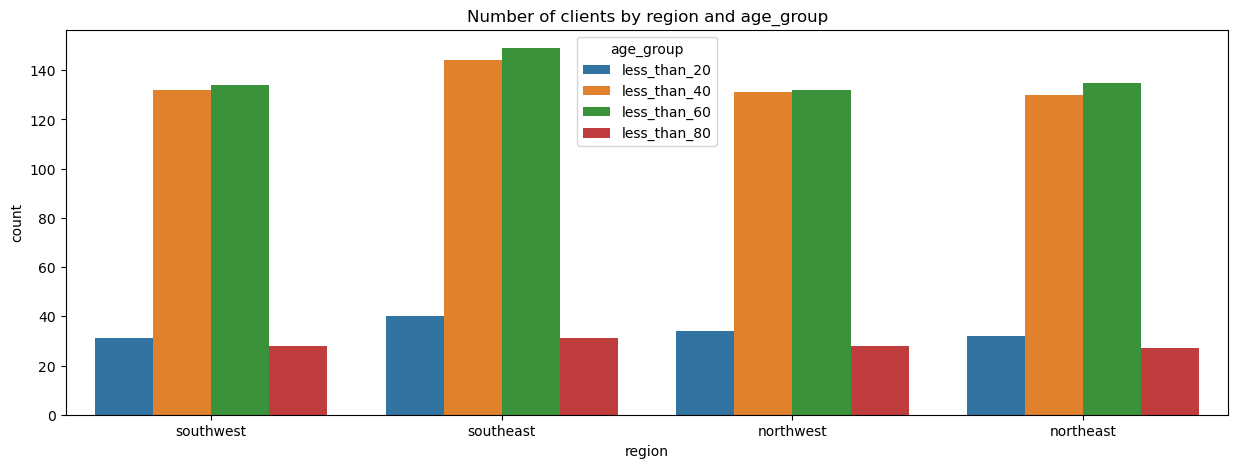

In [88]:
plt.figure(figsize=(15,5))
sns.countplot(data=df, x='region', hue='age_group')
plt.title('Number of clients by region and age_group')
plt.show()

### `boxplot of Body Mass Index bmi based on gender and age-group`

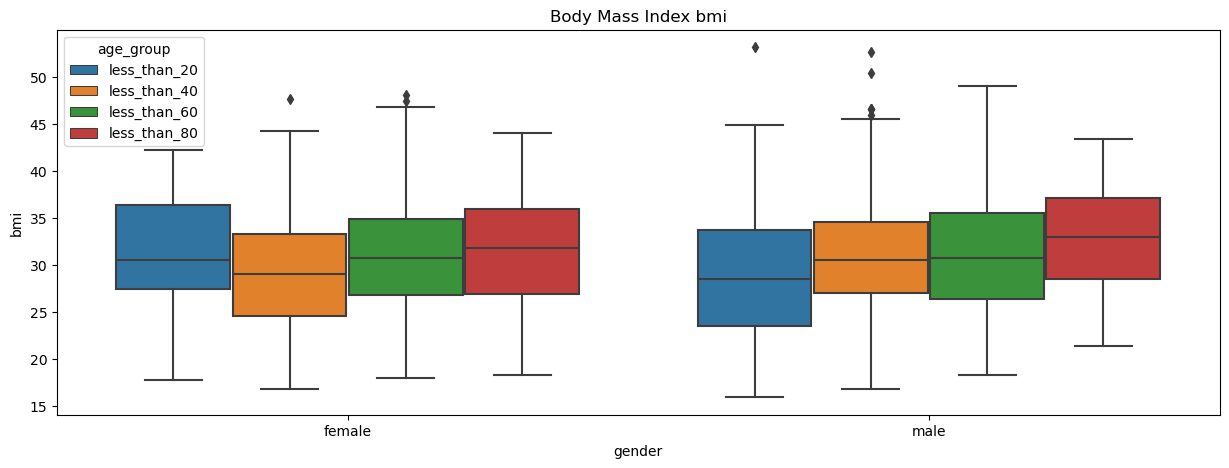

In [89]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, y='bmi', x='gender', hue='age_group')
plt.title('Body Mass Index bmi')
plt.show()

### `Scatterplot of charges based age, smoker/non-smoker and bmi`

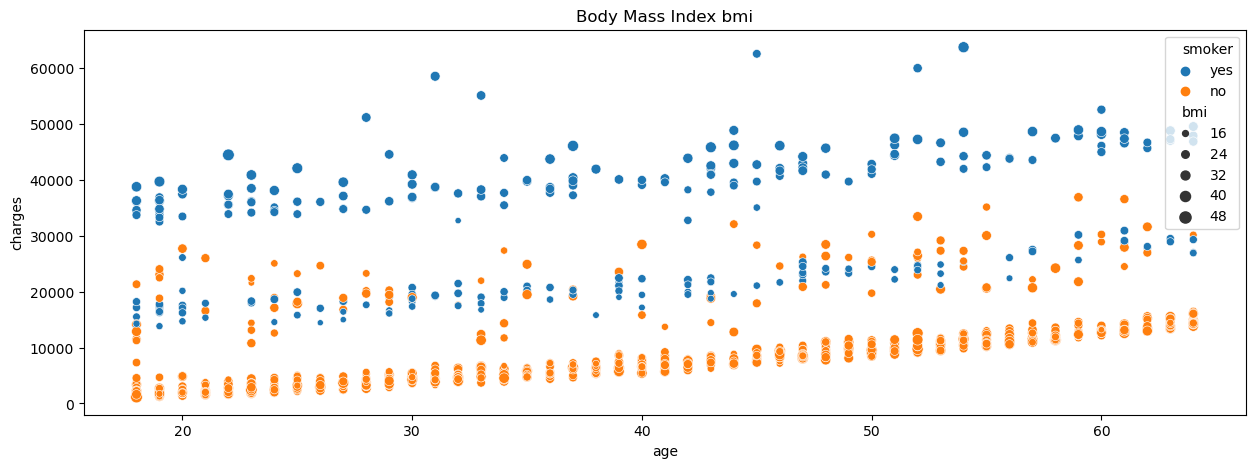

In [90]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=df, y='charges', x='age', hue='smoker', size='bmi' )
plt.title('Body Mass Index bmi')
plt.show()

Conclusion:
- Charges increases for smokers

## `Preprocessing`

### `Split Data into train and validation datasets`

In [92]:
## Features and target
X = df.drop(columns=['charges'], axis=1)
y = df['charges']

## to full train and test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=45)

print('X_train shape', X_train.shape)
print('X_valid shape', X_valid.shape)
print('y_train shape', y_train.shape)
print('y_valid shape', y_valid.shape)

X_train shape (1070, 7)
X_valid shape (268, 7)
y_train shape (1070,)
y_valid shape (268,)


#### `Data Preprocessing`

In [93]:
## Slice cols
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
categ_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(categ_cols) 
print(num_cols)

['gender', 'smoker', 'region', 'age_group']
['age', 'bmi', 'children']


In [94]:
## Pipeline 

## Numerical --> Impute using median, Standardization
## Cateforical --> Impute using mode, Ordinal


In [95]:
## Numerical
num_pipline = Pipeline(steps=[
                ('selector', DataFrameSelector(num_cols)),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ])

## Categorical
categ_pipline = Pipeline(steps=[
                 ('selector', DataFrameSelector(categ_cols)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder())
])


## Combine all
all_pipeline = FeatureUnion(transformer_list=[
                        ('num', num_pipline),
                        ('categ', categ_pipline)
                    ])

## apply
X_train_final  = all_pipeline.fit_transform(X_train)
X_valid_final = all_pipeline.transform(X_valid)



In [96]:
## Check shapes

print('X_train_final.shape \t', X_train_final.shape)
print('y_train_encoded.shape \t', y_train.shape)
print('**'*20)
print('X_valid_final.shape \t', X_valid_final.shape)
print('y_valid_encoded.shape \t', y_valid.shape)  ## fine

X_train_final.shape 	 (1070, 7)
y_train_encoded.shape 	 (1070,)
****************************************
X_valid_final.shape 	 (268, 7)
y_valid_encoded.shape 	 (268,)


## `Building Models`

`Let's consider evaluation metric f1_score `

#### 1. Linear Regression

In [97]:
## Model Training
lin_reg = LinearRegression()
lin_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_lin = lin_reg.predict(X_train_final)
y_pred_valid_lin = lin_reg.predict(X_valid_final)

## Evaluate
score_train_lin = r2_score(y_train, y_pred_train_lin)
score_valid_lin = r2_score(y_valid, y_pred_valid_lin)

print(f'R2 Score for Training Dataset using LinearRegression {score_train_lin * 100 :.3f}')
print(f'R2 Score for Valid Dataset using LinearRegression {score_valid_lin * 100 :.3f}')

R2 Score for Training Dataset using LinearRegression 76.037
R2 Score for Valid Dataset using LinearRegression 70.352


#### 2. Polynomail Features

In [98]:
# Initialize Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Polynomial fitting and transforming
X_train_final2 = poly.fit_transform(X_train_final)
X_valid_final2 = poly.transform(X_valid_final)


## Model Training
lin_poly_reg = LinearRegression()
lin_poly_reg.fit(X_train_final2, y_train)

## Predict and evaluate 
y_pred_train_lin_poly = lin_poly_reg.predict(X_train_final2)
y_pred_valid_lin_poly = lin_poly_reg.predict(X_valid_final2)

## Evaluate
score_train_lin_poly = r2_score(y_train, y_pred_train_lin_poly)
score_valid_lin_poly = r2_score(y_valid, y_pred_valid_lin_poly)

print(f'R2 Score for Training Dataset using LinearRegression with PolynomialFeatures {score_train_lin_poly * 100 :.3f}')
print(f'R2 Score for Valid Dataset using LinearRegression with PolynomialFeatures {score_valid_lin_poly * 100 :.3f}')

R2 Score for Training Dataset using LinearRegression with PolynomialFeatures 85.303
R2 Score for Valid Dataset using LinearRegression with PolynomialFeatures 81.565


#### 3. Random Forest

In [99]:
## Model Training
forst_reg = RandomForestRegressor(n_estimators=150, max_depth=5, random_state=45)
forst_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_forest = forst_reg.predict(X_train_final)
y_pred_valid_forest = forst_reg.predict(X_valid_final)

## Evaluate
score_train_forest = r2_score(y_train, y_pred_train_forest)
score_valid_forest = r2_score(y_valid, y_pred_valid_forest)

print(f'R2 Score for Training Dataset using RF {score_train_forest * 100 :.3f}')
print(f'R2 Score for Valid Dataset using RF {score_valid_forest * 100 :.3f}')

R2 Score for Training Dataset using RF 89.703
R2 Score for Valid Dataset using RF 83.523


#### 4. KNN

In [100]:
## Model Training
knn_reg = KNeighborsRegressor(n_neighbors=40, p=1, n_jobs=-1)
knn_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_knn = knn_reg.predict(X_train_final)
y_pred_valid_knn = knn_reg.predict(X_valid_final)

## Evaluate
score_train_knn = r2_score(y_train, y_pred_train_knn)
score_valid_knn = r2_score(y_valid, y_pred_valid_knn)

print(f'R2 Score for Training Dataset using knn {score_train_knn * 100 :.3f}')
print(f'R2 Score for Valid Dataset using knn {score_valid_knn * 100 :.3f}')

R2 Score for Training Dataset using knn 56.937
R2 Score for Valid Dataset using knn 53.676


#### 5. SGD with Early Stopping

In [101]:
## Model Training
SGD_reg = SGDRegressor(penalty=None, learning_rate='constant', eta0=0.001, early_stopping=True, 
                       n_iter_no_change=100, validation_fraction=0.1, max_iter=5000)
SGD_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_SGD = SGD_reg.predict(X_train_final)
y_pred_valid_SGD = SGD_reg.predict(X_valid_final)

## Evaluate
score_train_SGD = r2_score(y_train, y_pred_train_SGD)
score_valid_SGD = r2_score(y_valid, y_pred_valid_SGD)

print(f'R2 Score for Training Dataset using SGDRegressor {score_train_SGD * 100 :.3f}')
print(f'R2 Score for Valid Dataset using SGDRegressor {score_valid_SGD * 100 :.3f}')

R2 Score for Training Dataset using SGDRegressor 76.012
R2 Score for Valid Dataset using SGDRegressor 70.417


#### 6. Ensemble Learning: Voting

In [105]:
## Voting for (LinearRegression, RandomForest, KNeighbors, SGDRegressor) 
voting_reg = VotingRegressor(estimators=[
                                    ('lin_reg', lin_reg),
                                    ('forst_reg', forst_reg),
                                    ('knn_reg ', knn_reg ),
                                    ('SGD_reg', SGD_reg)
                                        ])


voting_reg.fit(X_train_final, y_train) 

## Predict and evaluate 
y_pred_train_voting = voting_reg.predict(X_train_final)
y_pred_valid_voting = voting_reg.predict(X_valid_final)

## Evaluate
score_train_voting = r2_score(y_train, y_pred_train_voting)
score_valid_voting = r2_score(y_valid, y_pred_valid_voting)

print(f'R2 Score for Training Dataset using voting {score_train_voting * 100 :.3f}')
print(f'R2 Score for Valid Dataset using voting {score_valid_voting * 100 :.3f}')

R2 Score for Training Dataset using voting 81.297
R2 Score for Valid Dataset using voting 77.092


#### 7. Ensemble Learning: Bagging -> RandomForest

In [116]:
## Model Training
forst_reg = RandomForestRegressor(n_estimators=150, max_depth=5, max_features=0.8, random_state=45,
                                    max_samples=0.8, bootstrap=True, oob_score=True)
forst_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_forest = forst_reg.predict(X_train_final)
y_pred_valid_forest = forst_reg.predict(X_valid_final)

## Evaluate
score_train_forest = r2_score(y_train, y_pred_train_forest)
score_valid_forest = r2_score(y_valid, y_pred_valid_forest)

print(f'R2 Score for Training Dataset using Bagging - RF {score_train_forest * 100 :.3f}')
print(f'R2 Score for Valid Dataset using Bagging - RF {score_valid_forest * 100 :.3f}')

R2 Score for Training Dataset using Bagging - RF 89.336
R2 Score for Valid Dataset using Bagging - RF 83.555


#### 8. Ensemble Learning: Boosting -> AdaBoost

In [117]:
## Model Training
adaboost_reg = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=5, 
                                                                        max_features=0.8, random_state=48),
                                    n_estimators=150, learning_rate=1)
adaboost_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_adaboost = adaboost_reg.predict(X_train_final)
y_pred_valid_adaboost = adaboost_reg.predict(X_valid_final)

## Evaluate
score_train_adaboost = r2_score(y_train, y_pred_train_adaboost)
score_valid_adaboost = r2_score(y_valid, y_pred_valid_adaboost)

print(f'R2 Score for Training Dataset using AdaBoostRegressor {score_train_adaboost * 100 :.3f}')
print(f'R2 Score for Valid Dataset using AdaBoostRegressor {score_valid_adaboost * 100 :.3f}')

R2 Score for Training Dataset using AdaBoostRegressor 69.806
R2 Score for Valid Dataset using AdaBoostRegressor 58.796


#### 9. Ensemble Learning: Boosting -> GradientBoosting

In [119]:
## Model Training
gradient_reg = GradientBoostingRegressor(n_estimators=150, max_depth=5, learning_rate=0.1)
gradient_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_gradient = gradient_reg.predict(X_train_final)
y_pred_valid_gradient = gradient_reg.predict(X_valid_final)

## Evaluate
score_train_gradient = r2_score(y_train, y_pred_train_gradient)
score_valid_gradient = r2_score(y_valid, y_pred_valid_gradient)

print(f'R2 Score for Training Dataset using GradientBoosting {score_train_gradient * 100 :.3f}')
print(f'R2 Score for Valid Dataset using GradientBoosting {score_valid_gradient * 100 :.3f}')

R2 Score for Training Dataset using GradientBoosting 97.741
R2 Score for Valid Dataset using GradientBoosting 80.049


#### 10. XGBoost

In [126]:
## Model Training
XGB_reg = XGBRegressor(n_estimators=120, max_depth=5, 
                        colsample_bytree=0.8, subsample=0.9, reg_lambda=100, learning_rate=0.2)
XGB_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_XGB = XGB_reg.predict(X_train_final)
y_pred_valid_XGB = XGB_reg.predict(X_valid_final)

## Evaluate
score_train_XGB = r2_score(y_train, y_pred_train_XGB)
score_valid_XGB = r2_score(y_valid, y_pred_valid_XGB)

print(f'R2 Score for Training Dataset using XGBRegressor {score_train_XGB * 100 :.3f}')
print(f'R2 Score for Valid Dataset using XGBRegressor {score_valid_XGB * 100 :.3f}')

R2 Score for Training Dataset using XGBRegressor 91.272
R2 Score for Valid Dataset using XGBRegressor 83.289
